### Importing all required libraries

In [1]:
import os
import torch
import numpy as np
import rasterio as rio
import matplotlib.pyplot as plt
import sklearn
import warnings

warnings.filterwarnings("ignore")

### Helper function to get dataset files

In [2]:
def get_list_of_files(data_path: str=r'./splits') -> list[tuple[str, str]]:
    file_paths = []
    data_folders = ["test", "train", "val"]
    
    for each in data_folders:
        # ../splits/[test/train/val]/input
        input_folder = os.path.join(data_path, each, 'input')
        # ../splits/[test/train/val]/target 
        target_folder = os.path.join(data_path, each, 'target')
    
        # check to make sure folders exist
        if not os.path.isdir(input_folder): raise FileNotFoundError(f'Input folder {input_folder} not found')
        if not os.path.isdir(target_folder): raise FileNotFoundError(f'Target folder {target_folder} not found')
        
        # grab tifs
        input_tifs = [f for f in os.listdir(input_folder) if f.endswith('.tif')]
        
        for input_tif in input_tifs:
            # try to look for corresponding tifs in target dir
            target_tif = os.path.join(target_folder, input_tif)
            if os.path.isfile(target_tif):
                file_paths.append((os.path.join(input_folder, input_tif), target_tif)) # add input_tif's and matching target tif's loc
            
    return file_paths

file_paths = get_list_of_files(r'/home/kevin/Aayam/U-NET/splits')
print(f'Found \033[35m{len(file_paths)}\033[0m files!')

Found 250 files!


### Demo of rasterio

In [3]:
src_file = file_paths[0][0]
with rio.open(src_file) as src:
    meta = src.meta        # grab geo metadata
    data = src.read()      # grab raster data as numpy array
    red_band = src.read(1) # only grab red band as numpy array

print(f"""\033[35mRaster metadata:\033[0m {meta}
\033[35mRaster shape:\033[0m {data.shape}
\033[35mRed band raster shape:\033[0m {red_band.shape}
""")

Raster metadata: {'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 256, 'height': 256, 'count': 3, 'crs': CRS.from_wkt('PROJCS["unknown",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",32.5],PARAMETER["central_meridian",-89.75],PARAMETER["scale_factor",0.9998335],PARAMETER["false_easting",500000],PARAMETER["false_northing",1300000],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'), 'transform': Affine(1.0, 0.0, 531037.9870497471,
       0.0, -1.0, 1069981.8776918147)}
Raster shape: (3, 256, 256)
Red band raster shape: (256, 256)



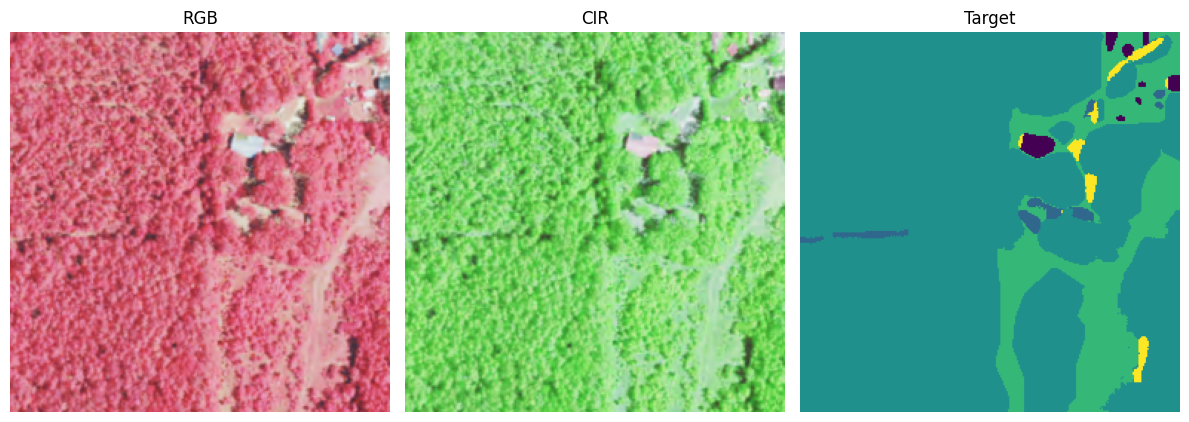

In [4]:
data_rgb = data[:3]               # create RGB image of src_file
data_cir = data[[2, 0, 1], :, :]  # grab only the GR NIR bands


# grab the corresponding target file for the src_file
target_file = file_paths[0][1]
with rio.open(target_file) as src:
    target_meta = src.meta  # grab geo metadata
    target = src.read()     # grab raster data as numpy array


img_files = [data_rgb, data_cir, target]
img_titles = ["RGB", "CIR", "Target"]

f, ax = plt.subplots(1, 3, figsize=(12, 5))
for idx, (img, title) in enumerate(zip(img_files, img_titles)):
    ax[idx].imshow(img.transpose(1, 2, 0))  # transpose to reorder the dimensions
    ax[idx].set_title(title)
    ax[idx].axis('off')
plt.tight_layout()

In [5]:
def print_array_info(array):
    print('\033[35mArray shape:\033[0m', array.shape)
    print('\033[35mArray dtype:\033[0m', array.dtype)
    print('\033[35mArray range:\033[0m', array.min(), array.max())
    
print_array_info(data)
print_array_info(target)

Array shape: (3, 256, 256)
Array dtype: uint8
Array range: 32 248
Array shape: (1, 256, 256)
Array dtype: uint8
Array range: 2 8


### Functionalizing the above code

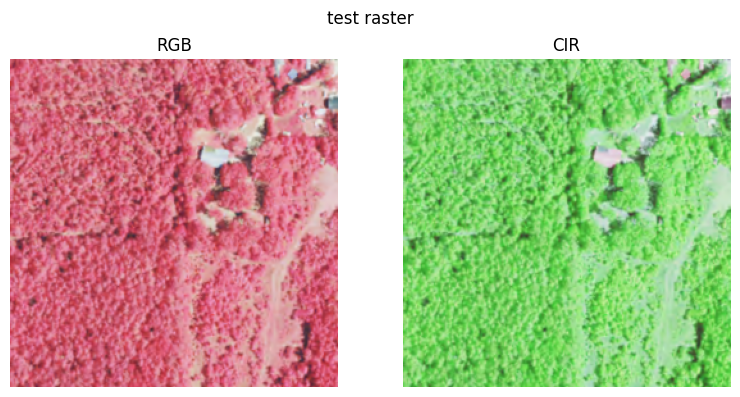

In [6]:
def visualize_raster(raster, title=None):

    rgb = raster[:3]              # create RGB image
    cir = raster[[2, 0, 1], :, :] # grab only the G R NIR bands

    rgb = rgb.transpose(1, 2, 0)
    cir = cir.transpose(1, 2, 0)

    fig, ax = plt.subplots(1, 2, figsize=(8, 4))
    img_data = [rgb, cir]; img_title = ["RGB", "CIR"]
    for idx, (img, ttl) in enumerate(zip(img_data, img_title)):
        ax[idx].imshow(img, vmin=0, vmax=255)
        ax[idx].set_title(ttl)
        ax[idx].axis('off')

    fig.suptitle(title)
    fig.tight_layout()
    plt.show()

visualize_raster(data, 'test raster')

### Image data labels & target viz

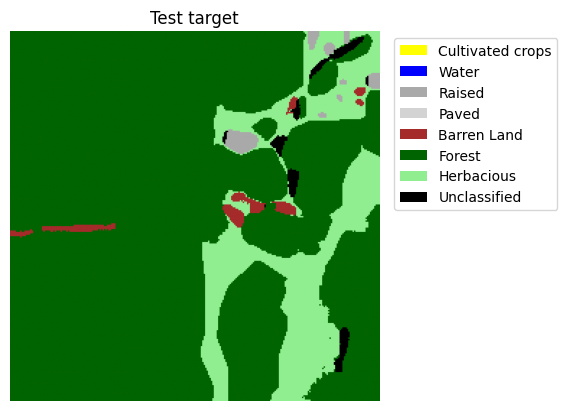

In [7]:
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

land_cover = {
    'Cultivated crops': 'yellow',
    'Water': 'blue',
    'Raised': 'darkgray',
    'Paved': 'lightgray',
    'Barren Land': 'brown',
    'Forest': 'darkgreen',
    'Herbacious': 'lightgreen',
    'Unclassified': 'black'
}

land_cover_cmap = ListedColormap(land_cover.values(), name='land-cover') # create color map object
land_cover_legend=[Patch(label = label, facecolor=color) for label, color in land_cover.items()]


# Make function similar to visualize_raster
def visualize_target(target, title=None):
    
    if target.ndim == 3:
        target = target.squeeze(0) # remove extra dimension if necessary

    plt.imshow(target, cmap=land_cover_cmap, vmin=0, vmax=8)
    plt.axis('off')
    plt.legend(handles=land_cover_legend, loc='upper right', bbox_to_anchor=(1.5, 1))
    plt.title(title)
    plt.show()

visualize_target(target, 'Test target')

### Display plot class distribution

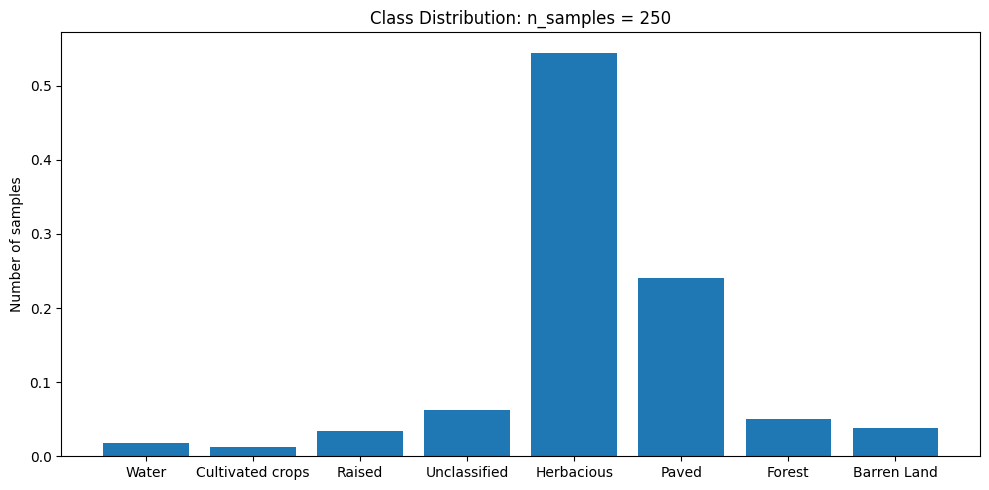

In [15]:
def plot_class_distribution(y):
    class_dist = np.unique(y, return_counts=True)[1] # get counts of each class
    class_dist = class_dist / class_dist.sum()       # standardize to sum to 1

    plt.figure(figsize=(10, 5)) 
    plt.bar(range(len(class_dist)), class_dist)
    plt.xticks(ticks=range(len(class_dist)), labels=[list(land_cover.keys())[i] for i in np.argsort(class_dist)])
    plt.ylabel('Number of samples')
    plt.title(f'Class Distribution: n_samples = {len(y)}')
    plt.tight_layout()
    plt.show()

    return class_dist
    
y = np.array([rio.open(target_file).read() for _, target_file in file_paths])
y_class_dist = plot_class_distribution(y)

### Splitting the dataset

In [9]:
from sklearn.model_selection import train_test_split

X, y = zip(*file_paths)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

print(f"""\033[35mTotal samples:\033[0m {len(X)}
\033[35mTraining samples:\033[0m {len(X_train)}
\033[35mTest samples:\033[0m {len(X_test)}
\033[35mValidation samples:\033[0m {len(X_val)}
""")

Total samples: 250
Training samples: 150
Test samples: 50
Validation samples: 50



### Custom dataset class

In [10]:
from torch.utils.data import Dataset

# our custom GCER_Dataset class will inherit from the Dataset class
class GCER_Dataset(Dataset):

    def __init__(self, files: list[tuple[str, str]], transform=None):
        self.file_path_list = files
        self.transform = transform # more on this later
        self.class_dist = None     # we will use this later
        
        # min and max values of the imagery (per bands)
        X = np.array([rio.open(file[0]).read() for file in self.file_path_list])
        self.mins = X.min(axis=(0, 2, 3), keepdims=True).squeeze(0)
        self.maxs = X.max(axis=(0, 2, 3), keepdims=True).squeeze(0)
        self.range = self.maxs - self.mins
        
    def __len__(self):
        return len(self.file_path_list)
    
    # __getitem__() is called when indexed in the form dataset[i]
    # typically a __getitem__() method returns a single sample from the dataset
    # in the form of a tuple: (X, y) where X is the data fed into
    # the model and y is the ground truch label associated with the data.
    def __getitem__(self, index) -> tuple[torch.Tensor, torch.Tensor, dict]:
        
        file_path = self.file_path_list[index] # get file path to laod
        
        # load raster data to memory
        X = rio.open(file_path[0]).read()
        y = rio.open(file_path[1]).read()
        
        # convert to torch tensors
        X = torch.from_numpy(X).type(torch.FloatTensor) # convert to float tensor
        y = torch.from_numpy(y).type(torch.FloatTensor) # convert to float tensor
        
        # standardize input data
        X = np.subtract(X, self.mins) # subtract min
        X = np.divide(X, self.range) # divide by range
        
        return X, y


    def get_class_distribution(self, density: bool=True) -> np.array:
        
        if self.class_dist is not None: return self.class_dist # return cached result if available
        
        # load all labels into memory (as numpy array)
        labels = np.array([rio.open(file_path[1]).read() for file_path in self.file_path_list])
                
        # get class distribution using numpy histogram function
        self.class_dist = np.histogram(labels, bins=8, density=density, range=(0, 9))[0]
        
        return self.class_dist

    
    def plot_class_distributuion(self) -> np.array:
        
        class_dist = self.get_class_distribution()
        
        fig, ax = plt.subplots(1, 1, figsize=(10, 5))
        ax.bar(range(len(class_dist)), class_dist)
        ax.set_xticks(range(len(class_dist)))
        ax.set_xticklabels(land_cover_labels)
        
        ax.set_ylabel('Number of Samples')
        ax.set_title(f'Class Distribution: n_samples = {self.__len__()}')
        fig.tight_layout()
        plt.show()
        
        return class_dist

#### Testing the above function

Array shape: torch.Size([3, 256, 256])
Array dtype: torch.float32
Array range: tensor(0.0393) tensor(0.9880)
Array shape: torch.Size([1, 256, 256])
Array dtype: torch.float32
Array range: tensor(2.) tensor(8.)


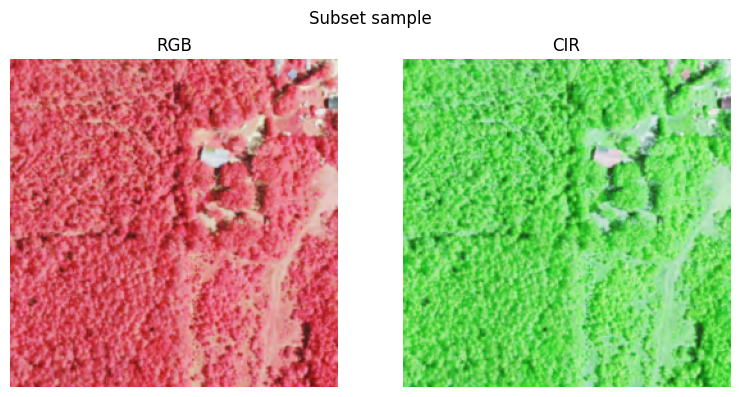

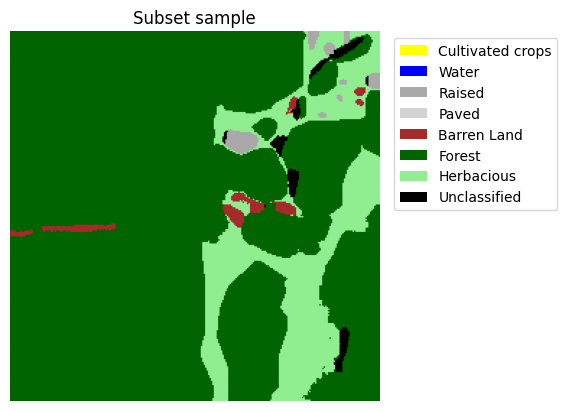

Number of samples in dataset: 5


NameError: name 'land_cover_labels' is not defined

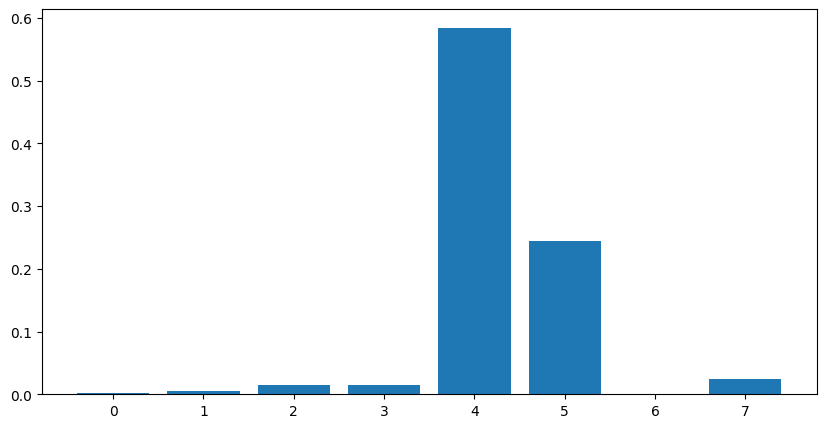

In [11]:
subset_files = file_paths[:5]               # select first 5 samples of full dataset for subset
subset_dataset = GCER_Dataset(subset_files) # create dataset object

X_temp, y_temp = subset_dataset[0] # get first sample in dataset
print_array_info(X_temp) # NOTE: because X and y are torch tensors, the output will vary sligtly from previous examples
print_array_info(y_temp)

visualize_raster(X_temp.numpy(), 'Subset sample')
visualize_target(y_temp.numpy(), 'Subset sample')

# check how many samples are in the dataset
print(f'Number of samples in dataset: {len(subset_dataset)}') # __len__ method has been overriden

# check class distribution
subset_dataset.plot_class_distributuion()

### Image data augmentation

In [ ]:
from torchvision.transforms.functional import rotate, hflip, vflip

class RotateAndFlipTransforms:
    
    def __init__(self) -> None:
        self.angles = [90, 180, 270] # possible angles to rotate (0 and 360 are the same as the original)
        self.p_rotate = 0.75 # probability of rotating
        self.p_flip = 0.5 # probability of flipping
    
    def __call__(self, X: torch.Tensor, y: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        
        # rotate with probability p_rotate
        if random.random() < self.p_rotate: 
            angle = random.choice(self.angles) # if rotating, choose a random angle
            X = rotate(X, angle)
            y = rotate(y, angle)

        # horizontal flip with probability p_flip
        if random.random() < self.p_flip: # horizontal flip with probability p_flip
            X = hflip(X)
            y = hflip(y)
            
        # vertical flip with probability p_flip
        if random.random() < self.p_flip:
            X = vflip(X)
            y = vflip(y)
        
        return X, y

transform = RotateAndFlipTransforms()

# testing the transform
X_temp_aug, y_temp_aug = transform(X_temp, y_temp)

# print array info
print_array_info(X_temp_aug)
print_array_info(y_temp_aug)

# visualize transformed data
# NOTE: should convert torch tensors to numpy arrays before visualizing
visualize_raster(X_temp.numpy(), title='Original raster')
visualize_raster(X_temp_aug.numpy(), title='Transformed raster')
visualize_target(y_temp.numpy(), title='Original target')
visualize_target(y_temp_aug.numpy(), title='Transformed target')

In [ ]:
train_dataset = GCER_Dataset(train_file_paths, transform=RotateAndFlipTransforms()) 
train_class_dist = train_dataset.get_class_distribution()
print('\033[35mClass distribution for training set:\033[0m', train_class_dist)

val_dataset = GCER_Dataset(val_file_paths) # no need for transforms on validation/test sets
val_class_dist = val_dataset.get_class_distribution()
print('\033[35mClass distribution for validation set:\033[0m', val_class_dist)

test_dataset = GCER_Dataset(test_file_paths)
test_class_dist = test_dataset.get_class_distribution()
print('\033[35mClass distribution for test set:\033[0m', test_class_dist)

### Defining U-Net model